In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
import dump
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

In [3]:
import Py_FTP_Langevin as ftp
import ftp_support

In [4]:
k_B = 1.38066e-23    #! Boltzmann constant in (J/K)
Na = 6.02214076 * pow(10,23) # 1/mol

In [5]:
fontsize_axis = 20
fontsize_legend = 16
fontsize_ticks = 14

# First time passage simulations

In [6]:
#//! *********** PARAMETERS PARTICLE PROPERTIES *********** !
MM,Rho_p,epsilon_lj,sigma_lj,_ = ftp_support.Get_params_particles("Soot")

#//! *********** SIMULATION PARAMETERS *********** !
N_runs = 300 #;
Box_L_factor_dmax = 70. #4 #; //! Box size as factor of D_p
T_g = 300. #;  1700          //! Fluid temperature
P_g = 101300. #;          //! Fluid pressure
phi_p = 0.01 / 100 #;   //! Particles number concentration (1000 ppm = 0.01)    
with_collisions = True
with_rel_motion = True
with_rotation = False

#//! *********** LANGEVIN PARAMETERS *********** !
run_taus_min = 120 #; // Keep in 100 to be accurate with LD theory (otherwise the 6*D*t is not strictly respected)
LD_dt_factor = 1e-03 #;

#//! *********** PARAMETERS INT. POTENTIALS *********** !
alpha_dp = 0.02 #0.01
direct = "/home/jose/Desktop/Gitlab/mitacs/mitacs_project/First_time_passage/FTP_Langevin_simulations/Simulations/aggregate_info";

In [7]:
model = ftp.Pymodel(direct)
model

In [8]:
Dp_all = np.logspace(np.log10(1),np.log10(1e+03),10) * (1e-09)
Dp = np.max(Dp_all)
#Dp = np.min(Dp_all)

k_BT = k_B * T_g
A = np.logspace(np.log10(0.5),np.log10(250),10) * k_BT
A = np.append(np.array([0]),A)

In [9]:
# Potential well analysis
e_well_i = np.zeros_like(A)
r_e_well_i = np.zeros_like(A)
factor_vdw_i = np.zeros_like(A)

for i in range(len(A)):
    e_well,r_e_well = ftp_support.Determine_pot_well(Dp,Dp,A[i],sigma_lj,k_BT)
    e_well_i[i] = e_well
    r_e_well_i[i] = r_e_well
    factor_vdw_i[i] = 1+r_e_well/(0.5*(Dp+Dp))

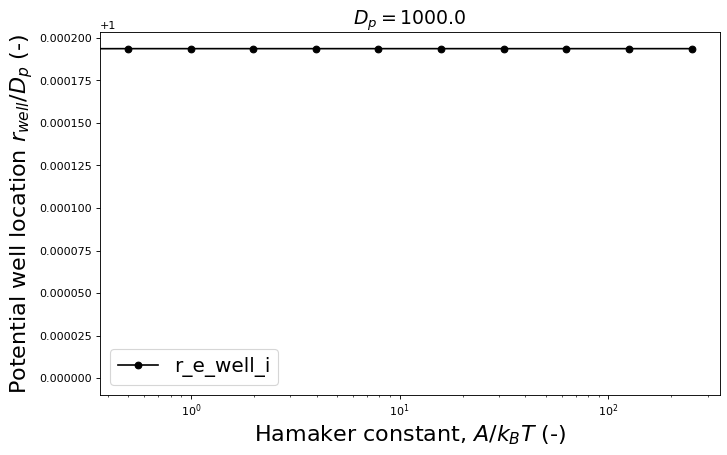

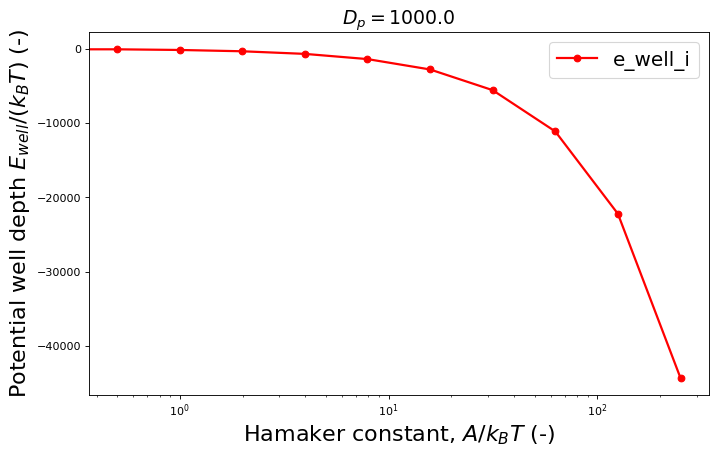

(<matplotlib.legend.Legend at 0x7f67c341d520>, None)

In [10]:
fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.plot(A/k_BT,r_e_well_i/Dp,"o-k",label="r_e_well_i")
title = "$D_p=$"+str(round(Dp*1e+09,2))
plt.title(title,fontsize=17); plt.xscale("log")
ax1.set_ylabel('Potential well location $r_{well}/D_p$ (-)', fontsize=20)
ax1.set_xlabel('Hamaker constant, $A/k_BT$ (-)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()

fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.plot(A/k_BT,e_well_i,"o-r", linewidth=2,label="e_well_i")
#ax1.plot(Dp*1e+09,r_e_well_i/Dp,".-k",label="r_e_well_i")
plt.title(title,fontsize=17); plt.xscale("log")
ax1.set_ylabel('Potential well depth $E_{well}/(k_BT)$ (-)', fontsize=20)
ax1.set_xlabel('Hamaker constant, $A/k_BT$ (-)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()

In [11]:
ftp.Init_Random()
ftp.Make_output_folder()

In [12]:
files = ftp.get_dir_files(direct)
N_files = len(files)

In [13]:
def isNaN(num):
    if float('-inf') < float(num) < float('inf'):
        return False 
    else:
        return True

In [14]:
factor_vdw = r_e_well_i[0]/Dp
model.Set_prop(MM,Rho_p,N_runs,Box_L_factor_dmax,
               T_g,P_g,phi_p,run_taus_min,LD_dt_factor,
               A[0],sigma_lj,alpha_dp,factor_vdw,Dp,
               with_collisions,with_rel_motion,with_rotation,direct)

ftp_model = ftp.PyFTP(model)

path_agg = direct + "/" + files[0].decode('utf-8')
print(path_agg)

/home/jose/Desktop/Gitlab/mitacs/mitacs_project/First_time_passage/FTP_Langevin_simulations/Simulations/aggregate_info/Agglomerate_N_000000001_Agg_00000001.dat


In [15]:
ftp_times_j = np.zeros(len(A))
ftp_times_std_j = np.zeros(len(A))
Kn_d_j = np.zeros(len(A))
Kn_g_j = np.zeros(len(A))
tau_12_j = np.zeros(len(A))
L_j = np.zeros(len(A))
Rc_j = np.zeros(len(A))
A_j = np.zeros(len(A))

In [16]:
for j in tqdm(range(len(A))):
    #print("Analysis: ",j)
    factor_vdw = r_e_well_i[j]/Dp
    model.Set_prop(MM,Rho_p,N_runs,Box_L_factor_dmax,
               T_g,P_g,phi_p,run_taus_min,LD_dt_factor,
               A[j],sigma_lj,alpha_dp,factor_vdw,Dp,
               with_collisions,with_rel_motion,with_rotation,direct)
    ftp_model.Load_aggregates_external(path_agg, model)
    ftp_times = np.asarray([])
    
    for k in range(N_runs):
        ftp_model.Restart_ftp(model)
        #ftp_model.show_spheres()
        #if (k == 0):
        #    ftp.Show_parameters(spheres2, model)
        ftp_model.Move_2_origin()
        ftp_model.Random_init_location()
        #Export_current_sim(ftp_model,0,True)
        i=1
        it_exp = 1
        collision = False
        while(not collision):
            collision = ftp_model.run(model, 1)
            if(isNaN(ftp_model.t_res)):
                print("d_time ",ftp_model.d_time, " t_res ",ftp_model.t_res)
                break
        i += 1
        ftp_times = np.append(ftp_times, ftp_model.t_res)
    ftp_times_std_j[j] = np.std(ftp_times)
    ftp_times_j[j] = np.mean(ftp_times)
    tau_12_j[j] = ftp_model.Tau_ij
    Kn_d_j[j] = ftp_model.Kn_d_ij
    Kn_g_j[j] = ftp_model.Kn_g_avg
    L_j[j] = ftp_model.L_box
    Rc_j[j] = ftp_model.Rc
    A_j[j] = A[j]

100%|██████████████████████████████████████████████████████████████████████████| 11/11 [73:50:37<00:00, 24167.07s/it]


In [17]:
# Box size
V_box = np.power(L_j,3)

t_ij = ftp_times_j/tau_12_j

H = V_box/(np.power(Rc_j,3)*t_ij)

In [18]:
Kn_d2 = np.logspace(np.log10(1e-02),np.log10(8e+02), 500)
H_theo = ftp_support.H_function(Kn_d2)

H_theo_d = ftp_support.H_diffusive(Kn_d2)
H_theo_b = ftp_support.H_ballistic(Kn_d2)

In [19]:
# Read Ouyang results
ouyang_res = pd.read_csv('old_results/Ouyang_res.dat', sep='\t')
ouyang_res.head()

A/(k_b*T)    n_C   n_FM
0        0.5  1.039  1.274
1        1.5  1.075  1.434
2        2.5  1.100  1.535
3        3.5  1.119  1.612
4        4.5  1.136  1.676

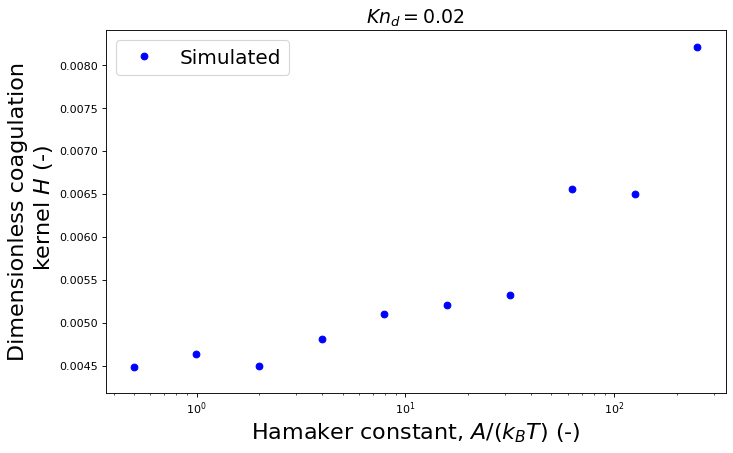

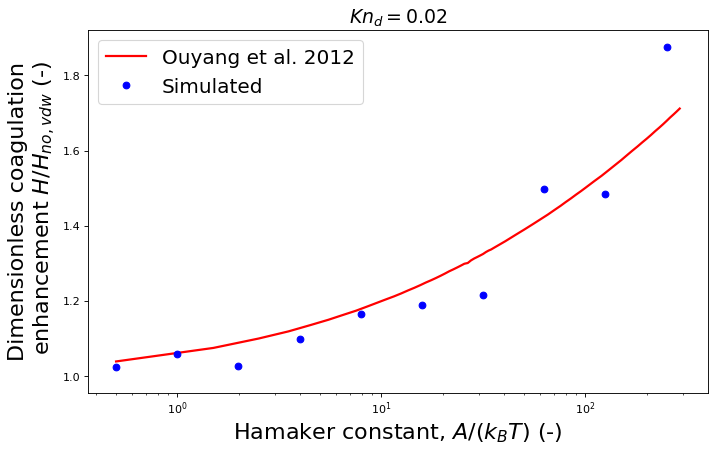

(<matplotlib.legend.Legend at 0x7f67bbc8f7c0>, None)

In [23]:
H_no_vdW = ftp_support.H_function(Kn_d_j[0])

fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
#ax1.loglog(A/k_BT,H_theo,"-r", linewidth=2,label="H_theo")
ax1.plot(A/k_BT,H,"o b",label="Simulated")
title = "$Kn_d=$"+str(round(Kn_d_j[0],2))
plt.title(title,fontsize=17)
plt.xscale("log")
ax1.set_xlabel('Hamaker constant, $A/(k_BT)$ (-)', fontsize=20)
ax1.set_ylabel('Dimensionless coagulation\n kernel $H$ (-)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()

fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.plot(ouyang_res["A/(k_b*T)"],ouyang_res["n_C"],"-r", linewidth=2,label="Ouyang et al. 2012")
#ax1.plot(ouyang_res["A/(k_b*T)"],ouyang_res["n_FM"],"-r", linewidth=2,label="Ouyang et al. 2012")
ax1.plot(A/k_BT,H/H[0],"o b",label="Simulated")
title = "$Kn_d=$"+str(round(Kn_d_j[0],2))
plt.title(title,fontsize=17)
plt.xscale("log")
ax1.set_xlabel('Hamaker constant, $A/(k_BT)$ (-)', fontsize=20)
ax1.set_ylabel('Dimensionless coagulation\n enhancement $H/H_{no,vdw}$ (-)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()

In [21]:
results_exp = np.column_stack((Kn_d_j,H,ftp_times_j,ftp_times_std_j,tau_12_j,Kn_g_j,
                              L_j,Rc_j,V_box,t_ij,A_j/k_BT))

file_name = "data_out/validation_spheres_with_vdw_diffusive.dat"
np.savetxt(file_name, results_exp, delimiter=",")